In [216]:
print(len(images))  

1731


In [217]:
import cv2
import os
import numpy as np

# Define the path to your directory
directory = r'C:\Users\nandu\data\train'

# Get a list of all the file paths
image_paths = [os.path.join(directory, img) for img in os.listdir(directory)]

# Load the images in grayscale
images = [cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) for img_path in image_paths]
pmw=[]
ir=[]
# cv2.imshow('image',images[0])
for i in range(len(images)):
    image1 = images[i][0:201, 0:201]
    image2 = images[i][0:201,201:402]
    image1=cv2.resize(image1,(256,256))
    image2=cv2.resize(image2,(256,256))
    image1=image1.reshape(256,256,1)
    image2=image2.reshape(256,256,1)
    pmw.append(image1)
    ir.append(image2)
pmw=np.array(pmw)
ir=np.array(ir)
print(pmw.shape)
# Now `images` is a list of numpy arrays representing your images in grayscale

(1731, 256, 256, 1)


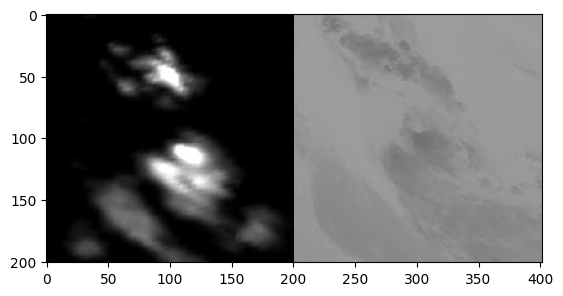

In [218]:
k=cv2.resize(pmw[0],(256,256))
import matplotlib.pyplot as plt 
plt.imshow(images[0],cmap='gray')
plt.show()

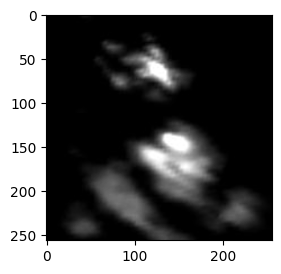

In [219]:
ax1=plt.subplot(121)
plt.imshow(k,cmap='gray')
plt.show()

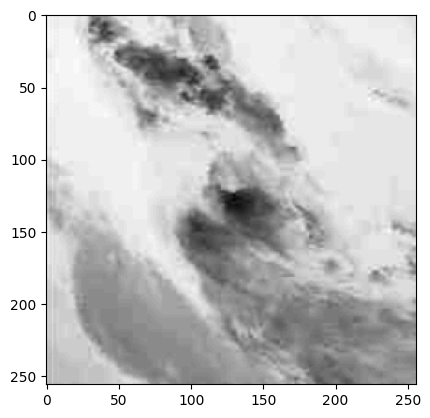

In [220]:
plt.imshow(ir[0],cmap='gray')
plt.show()

In [221]:
print(len(pmw))
print(pmw[0].shape)

1731
(256, 256, 1)


In [222]:
import tensorflow_addons as tfa

In [223]:
def define_discriminator(image_shape):
    init=tf.initializers.RandomNormal(stddev=0.02)
    in_image = tf.keras.layers.Input(shape=image_shape)
    #C64
    d= tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d= tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    #C128
    d= tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d=tfa.layers.InstanceNormalization(axis=-1)(d)
    d= tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    #C256
    d= tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d=tfa.layers.InstanceNormalization(axis=-1)(d)
    d= tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    #C512
    d= tf.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
    d=tfa.layers.InstanceNormalization(axis=-1)(d)
    d= tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    #second last output layer
    d= tf.keras.layers.Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d=tfa.layers.InstanceNormalization(axis=-1)(d)
    d= tf.keras.layers.LeakyReLU(alpha=0.2)(d)
    #patch output
    patch_out=tf.keras.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    model=tf.keras.models.Model(in_image, patch_out)
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model


In [224]:
def resnet_block(n_filters, input_layer):
    init=tf.initializers.RandomNormal(stddev=0.02)
    #first layer
    g= tf.keras.layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g=tfa.layers.InstanceNormalization(axis=-1)(g)
    g=tf.keras.layers.Activation('relu')(g)
    #second layer
    g= tf.keras.layers.Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g=tfa.layers.InstanceNormalization(axis=-1)(g)
    #concatenate merge
    g=tf.keras.layers.Concatenate()([g, input_layer])
    return g


In [225]:
def define_generator(image_shape,n_resnet=9):
    init=tf.initializers.RandomNormal(stddev=0.02)
    in_image = tf.keras.layers.Input(shape=image_shape)
    #c7s1-64
    g= tf.keras.layers.Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g=tfa.layers.InstanceNormalization(axis=-1)(g)
    g=tf.keras.layers.Activation('relu')(g)
    #d128
    g= tf.keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g=tfa.layers.InstanceNormalization(axis=-1)(g)
    g=tf.keras.layers.Activation('relu')(g)
    #d256
    g= tf.keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g=tfa.layers.InstanceNormalization(axis=-1)(g)
    g=tf.keras.layers.Activation('relu')(g)
    #R256
    for _ in range(n_resnet):
        g=resnet_block(256, g)
    #u128
    g= tf.keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g=tfa.layers.InstanceNormalization(axis=-1)(g)
    g=tf.keras.layers.Activation('relu')(g)
    #u64
    g= tf.keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g=tfa.layers.InstanceNormalization(axis=-1)(g)
    g=tf.keras.layers.Activation('relu')(g)
    #c7s1-3
    g= tf.keras.layers.Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g=tf.keras.layers.Activation('tanh')(g)
    model=tf.keras.models.Model(in_image, g)
    return model

In [226]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    g_model_1.trainable=True
    d_model.trainable=False
    g_model_2.trainable=False
    #discriminator
    input_gen = tf.keras.layers.Input(shape=image_shape)
    gen1 = g_model_1(input_gen)
    output_d = d_model(gen1)
    #identity
    input_id = tf.keras.layers.Input(shape=image_shape)
    output_id = g_model_1(input_id)
    #forward cycle
    output_f = g_model_2(gen1)
    #backward cycle
    gen2 = g_model_2(input_id)
    output_b = g_model_1(gen2)
    model = tf.keras.models.Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
    return model
def load_real_samples(data):
    # load compressed arrays
    X1, X2 = data[0], data[1]
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

In [227]:
def generate_real_samples(dataset, n_samples, patch_shape):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y
def generate_fake_samples(g_model, dataset, patch_shape):
    X = g_model.predict(dataset)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y
def save_models(step, g_model_AtoB, g_model_BtoA):
    filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
    g_model_AtoB.save(filename1)
    filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
    g_model_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))
def summarize_performance(step, g_model, trainX, name, n_samples=5):
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_in[i].astype('uint8'))
    for i in range(n_samples):
        plt.subplot(2, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_out[i].astype('uint8'))
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    plt.savefig(filename1)
    plt.close()
    print('>Saved: %s' % (filename1))
def update_image_pool(pool, images, max_size=50): 
    selected = list()
    for image in images:
        if len(pool) < max_size:
            pool.append(image)
            selected.append(image)
        elif np.random.random() < 0.5:
            selected.append(image)
        else:
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
    n_epochs, n_batch, = 100, 1
    n_patch = d_model_A.output_shape[1]
    trainA, trainB = dataset
    poolA, poolB = list(), list()
    bat_per_epo = int(len(trainA) / n_batch)
    n_steps = bat_per_epo * n_epochs
    for i in range(n_steps):
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        X_realB = tf.image.resize(X_realB, [256, 256])
        X_realA = tf.image.resize(X_realA, [256, 256])
        y_realA = tf.image.resize(y_realA, [256, 256])
        y_realB = tf.image.resize(y_realB, [256, 256])
        X_fakeA = tf.image.resize(X_fakeA, [256, 256])
        X_fakeB = tf.image.resize(X_fakeB, [256, 256])
        y_fakeA = tf.image.resize(y_fakeA, [256, 256])
        y_fakeB = tf.image.resize(y_fakeB, [256, 256])
        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
        if (i+1) % (bat_per_epo * 1) == 0:
            summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
            summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
        if (i+1) % (bat_per_epo * 5) == 0:
            save_models(i, g_model_AtoB, g_model_BtoA)

In [228]:
dataset=np.array([pmw,ir])
dataset=load_real_samples(dataset)
image_shape=dataset[0].shape[1:]
print(image_shape)
g_model_AtoB = define_generator(image_shape)
g_model_BtoA = define_generator(image_shape)
d_model_A = define_discriminator(image_shape)
d_model_B = define_discriminator(image_shape)
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

(256, 256, 1)


ValueError: Exception encountered when calling layer "model_65" (type Functional).

Input 0 of layer "conv2d_669" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 256, 256, 3)

Call arguments received by layer "model_65" (type Functional):
  • inputs=tf.Tensor(shape=(None, 256, 256, 3), dtype=float32)
  • training=None
  • mask=None

In [1]:
import cv2
import os
import numpy as np

# Define the path to your directory
directory = r'C:\Users\nandu\data\test'

# Get a list of all the file paths
image_paths = [os.path.join(directory, img) for img in os.listdir(directory)]

# Load the images in grayscale
images = [cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) for img_path in image_paths]
pmw=[]
ir=[]
# cv2.imshow('image',images[0])
for i in range(len(images)):
    image1 = images[i][0:201, 0:201]
    image2 = images[i][0:201,201:402]
    image1=cv2.resize(image1,(256,256))
    image2=cv2.resize(image2,(256,256))
    image1=image1.reshape(256,256,1)
    image2=image2.reshape(256,256,1)
    pmw.append(image1)
    ir.append(image2)
pmw=np.array(pmw)
ir=np.array(ir)
print(pmw.shape)

(5, 256, 256, 1)


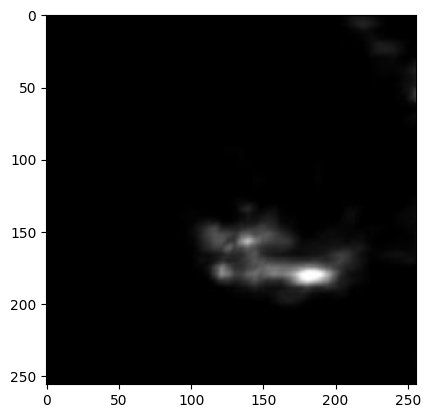

In [14]:
import matplotlib.pyplot as plt
def generate_real_samples(dataset, n_samples, patch_shape):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y
x,y=generate_real_samples(pmw,1,pmw.shape[1])
plt.imshow(x[0],cmap='gray')